In [1]:
%matplotlib inline

## Creating RTP synthetic data

Residuals:
  mean: 0.0031628423153 nT
  stddev: 3.44857200561 nT


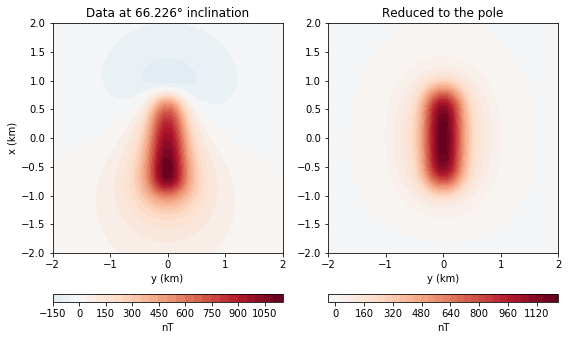

In [9]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from fatiando.gravmag import prism, sphere
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.inversion import Damping
from fatiando import gridder, utils, mesher

# First thing to do is make some synthetic data to test the method. We'll use a
# single prism with only induced magnetization to keep it simple
inc, dec = 66.226, 2.16
magnetization = 5
z0,z1 = 100,4000
props = {'magnetization': utils.ang2vec(magnetization, inc, dec)}
# model = [mesher.Prism(-500, 500, -200, 200, 50, 90, props)]
# model = [mesher.Prism(-2000, -1900, -200, 200, 50, 90, props)]
model =[mesher.Prism(-800, 800, -200, 200, z0, z1, props)]



# The synthetic data will be generated on a regular grid
area = [-2000, 2000, -2000, 2000]
shape = (40, 40)
x, y, z = gridder.regular(area, shape, z=-150)
# Generate some noisy data from our model
data = utils.contaminate(prism.tf(x, y, z, model, inc, dec), 0, seed=0)
data =prism.tf(x, y, z, model, inc, dec)

# Now for the equivalent layer. We must setup a layer of dipoles where we'll
# estimate a magnetization intensity distribution that fits our synthetic data.
# Notice that we only estimate the intensity. We must provide the magnetization
# direction of the layer through the sinc and sdec parameters.
layer = mesher.PointGrid(area, 700, shape)
eql = (EQLTotalField(x, y, z, data, inc, dec, layer, sinc=inc, sdec=dec)
       + 1e-15*Damping(layer.size))
eql.fit()
# Print some statistics of how well the estimated layer fits the data
residuals = eql[0].residuals()
print("Residuals:")
print("  mean:", residuals.mean(), 'nT')
print("  stddev:", residuals.std(), 'nT')

# Now I can forward model data anywhere we want. To reduce to the pole, we must
# provide inc = 90 (or -90) for the Earth's field as well as to the layer's
# magnetization.
layer.addprop('magnetization', utils.ang2vec(eql.estimate_, inc=-90, dec=0))
atpole = sphere.tf(x, y, z, layer, inc=-90, dec=0)


fig, axes = plt.subplots(1, 2, figsize=(8, 6))

ax = axes[0]
ax.set_title(u'Data at {}° inclination'.format(inc))
ax.set_aspect('equal')
amp = np.abs([data.min(), data.max()]).max()
tmp = ax.tricontourf(y/1000, x/1000, data, 30, cmap='RdBu_r', vmin=-amp,
                     vmax=amp)
# ax.plot([-200/1000 ,-200/1000, 200/1000, 200/1000,-200/1000],[-2000/1000,2000/1000, 2000/1000,-2000/1000,-2000/1000],ls="--",color="black")

fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_xlabel('y (km)')
ax.set_ylabel('x (km)')

ax = axes[1]
ax.set_title('Reduced to the pole')
ax.set_aspect('equal')
amp = np.abs([atpole.min(), atpole.max()]).max()
tmp = ax.tricontourf(y/1000, x/1000, atpole, 30, cmap='RdBu_r', vmin=-amp,
                     vmax=amp)
fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_xlabel('y (km)')
# ax.plot([-200/1000 ,-200/1000, 200/1000, 200/1000,-200/1000],[-2000/1000,2000/1000, 2000/1000,-2000/1000,-2000/1000],ls="--",color="black")
plt.tight_layout()
plt.show()


#### Saving Data


In [10]:
import pandas as pd
df = pd.DataFrame(x,columns=["x"])
df["y"]=y
df["z"]=z
df["data"]=data
df["atpole"]=atpole
df.to_csv(r"C:\Users\julik\sciebo\Master\Geophyphox\Synthetic Data\synthetic_RTP.csv")

## Creating upward continuation synthetic data

Residuals:
  mean: -0.0230366735246 nT
  stddev: 6.64446967397 nT


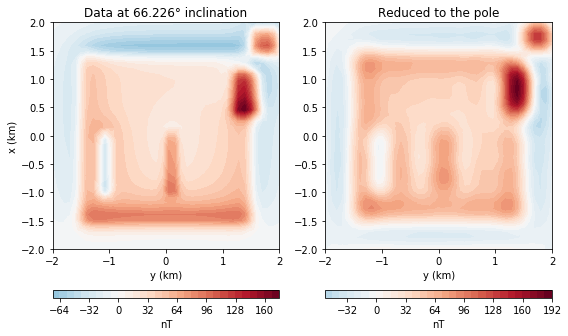

In [20]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from fatiando.gravmag import prism, sphere
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.inversion import Damping
from fatiando import gridder, utils, mesher

# First thing to do is make some synthetic data to test the method. We'll use a
# single prism with only induced magnetization to keep it simple
inc, dec = 66.226, 2.16
z0,z1  = 41,50
z0_1,z1_1 = 1,10
props = {'magnetization': utils.ang2vec(10, inc, dec)}
props2 = {'magnetization': utils.ang2vec(10, inc, dec)}

deep_structure = [mesher.Prism(-1500, 1500, -1500, 1500, z0,z1, props)]
model1 = [mesher.Prism(-1000, 100, 50, 150, z0_1,z1_1, props2)]
model2 = [mesher.Prism(-1000, 100, -1000, -1150, z0_1,z1_1, props2)]
model3 = [mesher.Prism(409, 1200, 1200, 1650,z0_1,z1_1, props2)]
model4 = [mesher.Prism(1500, 1950, 1500, 1950,z0_1,z1_1, props2)]
model = deep_structure+model1+model2+model3+model4


# The synthetic data will be generated on a regular grid
area = [-2000, 2000, -2000, 2000]
shape = (40, 40)
x, y, z = gridder.regular(area, shape, z=-150)
# Generate some noisy data from our model
# data = utils.contaminate(prism.tf(x, y, z, deep_structure+model2, inc, dec), 5, seed=0)
data =prism.tf(x, y, z, model, inc, dec)

# Now for the equivalent layer. We must setup a layer of dipoles where we'll
# estimate a magnetization intensity distribution that fits our synthetic data.
# Notice that we only estimate the intensity. We must provide the magnetization
# direction of the layer through the sinc and sdec parameters.
layer = mesher.PointGrid(area, 700, shape)
eql = (EQLTotalField(x, y, z, data, inc, dec, layer, sinc=inc, sdec=dec)
       + 1e-15*Damping(layer.size))
eql.fit()
# Print some statistics of how well the estimated layer fits the data
residuals = eql[0].residuals()
print("Residuals:")
print("  mean:", residuals.mean(), 'nT')
print("  stddev:", residuals.std(), 'nT')

# Now I can forward model data anywhere we want. To reduce to the pole, we must
# provide inc = 90 (or -90) for the Earth's field as well as to the layer's
# magnetization.
layer.addprop('magnetization', utils.ang2vec(eql.estimate_, inc=-90, dec=0))
atpole = sphere.tf(x, y, z, layer, inc=-90, dec=0)


fig, axes = plt.subplots(1, 2, figsize=(8, 6))

ax = axes[0]
ax.set_title(u'Data at {}° inclination'.format(inc))
ax.set_aspect('equal')
amp = np.abs([data.min(), data.max()]).max()
tmp = ax.tricontourf(y/1000, x/1000, data, 30, cmap='RdBu_r', vmin=-amp,
                     vmax=amp)
fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_xlabel('y (km)')
ax.set_ylabel('x (km)')

ax = axes[1]
ax.set_title('Reduced to the pole')
ax.set_aspect('equal')
amp = np.abs([atpole.min(), atpole.max()]).max()
tmp = ax.tricontourf(y/1000, x/1000, atpole, 30, cmap='RdBu_r', vmin=-amp,
                     vmax=amp)
fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_xlabel('y (km)')

plt.tight_layout()
plt.show()

#### Saving Data

In [16]:
df = pd.DataFrame(x,columns=["x"])
df["y"]=y
df["z"]=z
df["data"]=data
df.to_csv(r"C:\Users\julik\sciebo\Master\Geophyphox\Synthetic Data\synthetic_upward.csv")